The [General Bikeshare Feed Specification (GBFS)](https://github.com/NABSA/gbfs) is a popular standard for publishing live data about bikeshare systems used by systems [around the globe](https://github.com/NABSA/gbfs/blob/master/systems.csv). Its stated purpose is to allow 3rd party applications to interface with the live data and allow municipalities to monitor compliance with local regulations. For my purpose, it also allows me to monitor system usage in real time. Here I'll go through the steps I use to track bikeshare usage in real time using GBFS feeds. I currently publish live tracking of Vancouver bikeshare systems at [@VanBikeShareBot](http://twitter.com/vanbikesharebot) and will soon be adding tracking of Toronto, Hamilton and Montreal systems.

I've bundled the tools I use for GBFS monitoring into a python package that can be [found on Github](https://github.com/mjarrett/bikedata). The Bikedata package is not a full-service GBFS client -- for that, you might prefer [GBFS-client](https://pypi.org/project/gbfs-client/). Bikedata provides minimal functionality for querying GBFS feeds and returning Pandas dataframes, and implements some helper functions for persistent monitoring of bikeshare systems.  

## The GBFS spec

I won't go into detail about the GBFS spec, more information can be found on the project's [Github page](https://github.com/NABSA/gbfs). Suffice to say that a GBFS complient system offers several distinct JSON endpoints that provide information about the system. For example, Mobi Bikes in Vancouver provides:
* [https://vancouver-gbfs.smoove.pro/gbfs/gbfs.json](https://vancouver-gbfs.smoove.pro/gbfs/gbfs.json): A list of available feeds
* [https://vancouver-gbfs.smoove.pro/gbfs/en/system_information.json](https://vancouver-gbfs.smoove.pro/gbfs/en/system_information.json): General system information
* [https://vancouver-gbfs.smoove.pro/gbfs/en/station_information.json](https://vancouver-gbfs.smoove.pro/gbfs/en/station_information.json): Details about stations (short and long names, location, coordinates)
* [https://vancouver-gbfs.smoove.pro/gbfs/en/station_status.json](https://vancouver-gbfs.smoove.pro/gbfs/en/station_status.json): Live status of stations (bikes available, free docks)

Mobi doesn't have free floating bikes, but systems that do also have a `free_bikes.json` feed providing the location of available free floating bikes.

## Tracking station-based systems

Many bikeshare systems, especially those in dense city centres, only allow trips to begin and end at physical stations. To monitor these systems, I periodically query the `station_status.json` and record the number of bikes at each station. If the number of available bikes decreases by N, I count that as N departures from the station. If it increases by M, I count that as M bikes returned. 

<!-- TEASER_END -->


In [12]:
import pandas as pd
import json
import urllib
import datetime as dt
import time
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
def query_station_status(url):
    


    with urllib.request.urlopen(url) as data_url:
        data = json.loads(data_url.read().decode())


    df = pd.DataFrame(data['data']['stations'])
    # drop inactive stations
    df = df[df.is_renting==1]
    df = df[df.is_returning==1]
    df = df.drop_duplicates(['station_id','last_reported'])
    df.last_reported = df.last_reported.map(lambda x: dt.datetime.utcfromtimestamp(x))
    df['time'] = data['last_updated']
    df.time = df.time.map(lambda x: dt.datetime.utcfromtimestamp(x))
    df = df.set_index('time')
    df.index = df.index.tz_localize('UTC')

    return df

In [4]:
station_url = 'https://vancouver-gbfs.smoove.pro/gbfs/en/station_status.json'

In [6]:
df = query_station_status(station_url)

In [7]:
df.head()

,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,station_id
time,,,,,,,,
2020-01-19 19:32:01+00:00,1,1,1,2020-01-19 19:31:59,33,1,18,0001
2020-01-19 19:32:01+00:00,1,1,1,2020-01-19 19:25:32,8,0,20,0002
2020-01-19 19:32:01+00:00,1,1,1,2020-01-19 19:27:44,5,0,11,0004
2020-01-19 19:32:01+00:00,1,1,1,2020-01-19 19:31:01,13,0,13,0005
2020-01-19 19:32:01+00:00,1,1,1,2020-01-19 19:30:22,11,0,15,0006


In [10]:
df = pd.pivot_table(df,columns='station_id',index='time',values='num_bikes_available')

In [11]:
df

station_id,0001,0002,0004,0005,0006,0007,0008,0009,0010,0011,...,0274,0278,0280,0281,0282,0283,0285,0287,0297,0298
time,,,,,,,,,,,,,,,,,,,,,
2020-01-19 19:32:01+00:00,33,8,5,13,11,8,3,3,12,15,...,6,14,13,6,10,4,11,8,2,4


Running the above code periodically allows me to build up a dataframe with the number of bikes at each station at subsequent times. Below is an example that runs for 10 minutes.

In [14]:
stations_df = pd.DataFrame()

for i in range(10):
    df = query_station_status(station_url)
    df = pd.pivot_table(df,columns='station_id',index='time',values='num_bikes_available')
    stations_df = pd.concat([stations_df,df])
    time.sleep(60)

In [15]:
stations_df

station_id,0001,0002,0004,0005,0006,0007,0008,0009,0010,0011,...,0274,0278,0280,0281,0282,0283,0285,0287,0297,0298
time,,,,,,,,,,,,,,,,,,,,,
2020-01-19 19:41:01+00:00,32,8,5,13,13,8,3,3,12,15,...,6,14,13,6,10,4,11,8,2,3
2020-01-19 19:42:02+00:00,32,8,5,13,13,8,3,3,12,15,...,6,14,13,6,10,4,11,8,2,3
2020-01-19 19:43:03+00:00,32,8,5,13,13,8,3,3,12,15,...,6,14,13,6,10,4,11,8,2,3
2020-01-19 19:44:03+00:00,32,8,5,13,13,8,3,3,12,15,...,6,14,13,6,10,4,11,8,2,3
2020-01-19 19:45:04+00:00,32,8,5,13,13,8,3,3,12,15,...,6,14,13,6,10,4,11,8,2,3
2020-01-19 19:46:04+00:00,32,8,5,13,13,8,3,3,12,15,...,6,14,13,6,10,4,11,8,2,3
2020-01-19 19:47:05+00:00,32,8,5,13,13,8,3,3,12,15,...,6,14,13,6,10,4,11,8,2,3
2020-01-19 19:48:06+00:00,32,8,5,13,13,8,3,3,12,15,...,6,14,13,6,10,4,12,8,2,3
2020-01-19 19:49:06+00:00,32,8,5,13,13,8,3,3,12,15,...,6,14,13,6,10,4,12,8,2,3


To compute the number of trips started at each station at each time interval, I compute the difference in number of bikes between each successive query.

In [26]:
taken_df = stations_df - stations_df.shift(-1)
taken_df = taken_df.fillna(0.0).astype(int)
taken_df[taken_df>0] = 0
taken_df = taken_df*-1

In [30]:
taken_df

station_id,0001,0002,0004,0005,0006,0007,0008,0009,0010,0011,...,0274,0278,0280,0281,0282,0283,0285,0287,0297,0298
time,,,,,,,,,,,,,,,,,,,,,
2020-01-19 19:41:01+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-19 19:42:02+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-19 19:43:03+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-19 19:44:03+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-19 19:45:04+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-19 19:46:04+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-19 19:47:05+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-01-19 19:48:06+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-19 19:49:06+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Summing accross rows gives us the number of bikes taken during each interval. Summing accross columns gives us trips per station. Summing both gives us the total number of trips.

In [33]:
taken_df.sum(1)

time
2020-01-19 19:41:01+00:00    0
2020-01-19 19:42:02+00:00    0
2020-01-19 19:43:03+00:00    3
2020-01-19 19:44:03+00:00    0
2020-01-19 19:45:04+00:00    1
2020-01-19 19:46:04+00:00    1
2020-01-19 19:47:05+00:00    1
2020-01-19 19:48:06+00:00    0
2020-01-19 19:49:06+00:00    1
2020-01-19 19:50:07+00:00    0
dtype: int64

In [35]:
taken_df.sum().head()

station_id
0001    0
0002    0
0004    0
0005    0
0006    0
dtype: int64

In [32]:
taken_df.sum(1).sum()

7

There are some limitations to this method. The Mobi GBFS feed only updates every 60 seconds or so (this may vary across systems). If one person takes a bike from a station and another person returns a bike to that station within the same update period, no trip will be registered. These "collision" events can be estimated and accounted for (see Chardon et al, ["Estimating bike-share trips using station level data"](https://www.sciencedirect.com/science/article/pii/S0191261515000983)). Experimental physicists might be reminded of the concept of [dead time of a detector](https://en.wikipedia.org/wiki/Dead_time). I haven't yet implemented a correction for collision events in my work.

This model also doesn't account for bike rebalancing done by system staff. Staff periodically move bikes from crowded stations to empty stations to keep the system balanced. One might guess at rebalancing events by noting when a large amount of bikes appear or diseappear near-instantaneously at the same station. This also is not currently implemented in my work.

## Tracking free bike systems

Some bikeshare systems allow trips to be started and ended anywhere within the system boundary. This seems to be more popular with scooter share systems (which also use GBFS) and in smaller/less dense areas. As an example, I'll use HOPR bikeshare at the University of British Columbia. The procedure for tracking free bikes is very similar to tracking stations.

In [51]:
free_bikes_url = 'https://gbfs.hopr.city/api/gbfs/13/free_bike_status'

In [36]:
def query_free_bikes(url):

    with urllib.request.urlopen(url) as data_url:
        data = json.loads(data_url.read().decode())

    df = pd.DataFrame(data['data']['bikes'])
    df['bike_id'] = df['bike_id'].astype(str)

    df['time'] = data['last_updated']
    df.time = df.time.map(lambda x: dt.datetime.utcfromtimestamp(x))
    df = df.set_index('time')
    df.index = df.index.tz_localize('UTC')

    return df

In [39]:
df = query_free_bikes(free_bikes_url)

In [40]:
df.head()

,bike_id,geofence_zone_id,is_disabled,is_ebike,is_reserved,lat,lon
time,,,,,,,
2020-01-19 20:23:46+00:00,9116209d-030b-46f3-a48b-0e9c55c01497,1648.0,0,0,0,49.253378,-123.237307
2020-01-19 20:23:46+00:00,b3beb9f1-c686-4356-8113-86aa077bc581,NaN,0,0,0,49.261511,-123.255742
2020-01-19 20:23:46+00:00,b24d2b9b-4102-4442-a09f-6ad0595bdb09,NaN,0,0,0,49.269084,-123.252818
2020-01-19 20:23:46+00:00,1f444882-fc5e-4ede-9abd-0e85a3024670,1454.0,0,0,0,49.253604,-123.234578
2020-01-19 20:23:46+00:00,36a7b8ac-7073-4e77-92df-364463e8c83b,1672.0,0,0,0,49.254116,-123.235271


By querying the `free_bikes.json` feed, we retrieve the latitude and longitude of each available bike in the system, excluding bikes in use. (Sidenote: in working out this procedure, I [discovered a bug](https://github.com/NABSA/gbfs/issues/201) in some bikeshare systems that allowed the tracking of bikes while use). 

Initially I used the `bike_id` field to track free bikes; when a given `bike_id` disappears from the feed I would infer that that bike was in use, and when it returns to the feed I infer the trip is over. The GBFS maintainers have decided that this is a security vulnerability, presumably since if you know the ID of the bike an individual is using you can track where that person went with the bike. [In the future](https://github.com/NABSA/gbfs/pull/147), `bike_id` will either be rotated periodically or removed entirely from the feed so I no longer rely on it at all.

Instead, I truncat the coordinates of each bike to [4 decimal places](https://xkcd.com/2170/) and treat each coordinate as if it were a station. Most coordinates will only have one bike, but designated bike parking spots might have multiple bikes at the same coordinate.

In [44]:
df = df.round(4)
df['coords'] = list(zip(df.lat,df.lon))

In [49]:
df = pd.pivot_table(df,values='lat',index='time',columns='coords', aggfunc='count').fillna(0)

In [50]:
df

coords,"(49.2508, -123.2346)","(49.2509, -123.2344)","(49.2509, -123.2341)","(49.251, -123.2345)","(49.2511, -123.2345)","(49.2513, -123.2345)","(49.2514, -123.2332)","(49.2515, -123.233)","(49.2534, -123.2373)","(49.2536, -123.2346)",...,"(49.2681, -123.2517)","(49.2681, -123.2516)","(49.2681, -123.2515)","(49.2682, -123.2521)","(49.2683, -123.2511)","(49.2685, -123.2567)","(49.2686, -123.2563)","(49.2688, -123.2529)","(49.2691, -123.2528)","(49.2718, -123.25)"
time,,,,,,,,,,,,,,,,,,,,,
2020-01-19 20:23:46+00:00,1,2,1,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1


Similarly to above, let's query the `free_bikes.json` feed for 10 minutes and then infer trips by computing the change in number of bikes at each set of coordinates.

In [62]:
bikes_df = pd.DataFrame()

for i in range(10):
    df = query_free_bikes(free_bikes_url)
    df = df.round(4)
    df['coords'] = list(zip(df.lat,df.lon))
    df['coords'] = df['coords'].map(lambda x: str(x))
    df = pd.pivot_table(df,values='lat',index='time',columns='coords', aggfunc='count').fillna(0)
    bikes_df = pd.concat([bikes_df,df],sort=True)
    bikes_df = bikes_df.fillna(0)
    time.sleep(60)

In [63]:
bikes_df

,"(49.2508, -123.2346)","(49.2509, -123.2341)","(49.2509, -123.2344)","(49.251, -123.2345)","(49.2511, -123.2345)","(49.2513, -123.2345)","(49.2514, -123.2332)","(49.2515, -123.233)","(49.2534, -123.2373)","(49.2536, -123.2346)",...,"(49.2681, -123.2515)","(49.2681, -123.2516)","(49.2681, -123.2517)","(49.2682, -123.2521)","(49.2683, -123.2511)","(49.2685, -123.2567)","(49.2686, -123.2563)","(49.2688, -123.2529)","(49.2691, -123.2528)","(49.2718, -123.25)"
time,,,,,,,,,,,,,,,,,,,,,
2020-01-19 20:57:20+00:00,1,1,2,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1
2020-01-19 20:57:20+00:00,1,1,2,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1
2020-01-19 20:57:20+00:00,1,1,2,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1
2020-01-19 21:00:31+00:00,1,1,2,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1
2020-01-19 21:00:31+00:00,1,1,2,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1
2020-01-19 21:00:31+00:00,1,1,2,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1
2020-01-19 21:03:35+00:00,1,1,2,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1
2020-01-19 21:03:35+00:00,1,1,2,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1
2020-01-19 21:03:35+00:00,1,1,2,1,2,1,2,1,2,1,...,1,1,1,1,1,1,2,1,1,1


In [68]:
taken_df = (bikes_df - bikes_df.shift(1)).fillna(0).astype(int)
taken_df[taken_df>0] = 0
taken_df = taken_df*-1
taken_df = taken_df.stack()
taken_df = taken_df.reset_index()
taken_df.columns = ['time','coords','trips']
taken_df.coords = taken_df.coords.map(lambda y: tuple([float(x) for x in y.strip("'()").split(',')]))
taken_df = taken_df.set_index('time')
taken_df = taken_df[taken_df.trips > 0]

In [69]:
taken_df

,coords,trips
time,,
2020-01-19 21:06:37+00:00,"(49.2644, -123.2553)",1


In this example we only capture one trip during the 10 minutes of tracking. We have the coordinates of where the trip started but we don't its duration or where it ended. We can also track returns, but we can't match up departures with returns without more information. As discussed above, this is a deliberate decision by the GBFS maintainers to ensure user privacy.

Tracking free bikes runs into similar problems as tracking station-based systems. Bikes taken offline for any reason -- rebalancing, maintenance, disabled -- will be counted as a trip. There is also still the possibility of collision events if a bike is left at a bike rack just as a different bike is taken from the same rack, or if a one bike is used for two consecutive trips by different people without enough time between the trips for the bike to show back up in the feed. 

## Hybrid systems

Some systems, such as Hamilton's SoBi bikeshare, combine the station-based and free bike models. Trips typically start and end at designated stations, but for a small fee users can leave bikes locked up anywhere in the system zone. To track these systems, I run both the station-based and free-bikes algorithms above and combine the counts to determine the total trips in the system.

Other systems, like HOPR at UBC, provide both the station and free bike feeds, but bikes are double counted. For example, a bike left at a designated "station" (in reality just marked area on the sidewalk) would show up in both feeds. In this case, I only watch the free bikes feed. Some familiarity with how each system actually operates is required to properly interpret the GBFS feed.

## Validation

Mobi generously provides [official system data](https://www.mobibikes.ca/en/system-data) of all trips taken since 2017. Here I'll use that the check how the official data compares to my tracking data. First, I'll load the system data. For this exercise, I'll limit the date range to January-September 2019 inclusive. I've done some minor cleaning of Mobi's official data to standardize field names and drop nonsensical records.

In [73]:
system_df = pd.read_csv('/home/msj/mobi-data/Mobi_System_Data_Prepped_full.csv',index_col=0,parse_dates=True)

In [77]:
system_df = system_df['2019-01-01':'2019-09-30']

In [179]:
system_daily_df = system_df.groupby(pd.Grouper(freq='d')).size()

In [181]:
system_daily_df.index = system_daily_df.index.tz_localize('America/Vancouver')

In [182]:
system_daily_df.head()

Departure
2019-01-01 00:00:00-08:00    837
2019-01-02 00:00:00-08:00    668
2019-01-03 00:00:00-08:00    256
2019-01-04 00:00:00-08:00    849
2019-01-05 00:00:00-08:00    855
Freq: D, dtype: int64

In [184]:
len(system_daily_df)

273

I'll similarly load my tracking data for the same period

In [110]:
tracking_df = pd.read_csv('/home/msj/bikeshares/mobi_bikes/data/taken_hourly.csv',index_col=0,parse_dates=True)

In [111]:
tracking_df.index = tracking_df.index.tz_convert('America/Vancouver')

In [112]:
tracking_df = tracking_df['2019-01-01':'2019-09-30']

In [190]:
tracking_daily_df = tracking_df.sum(1).groupby(pd.Grouper(freq='d')).sum()

In [191]:
tracking_daily_df.head()

time
2019-01-01 00:00:00-08:00    819.0
2019-01-02 00:00:00-08:00    768.0
2019-01-03 00:00:00-08:00    329.0
2019-01-04 00:00:00-08:00    915.0
2019-01-05 00:00:00-08:00    921.0
Freq: D, dtype: float64

In [187]:
len(tracking_hourly_df)

273

First let's look at a correlation plot. If my tracking estimates are exactly the same as the official data, they will plot at straight x=y line.

<IPython.core.display.Javascript object>


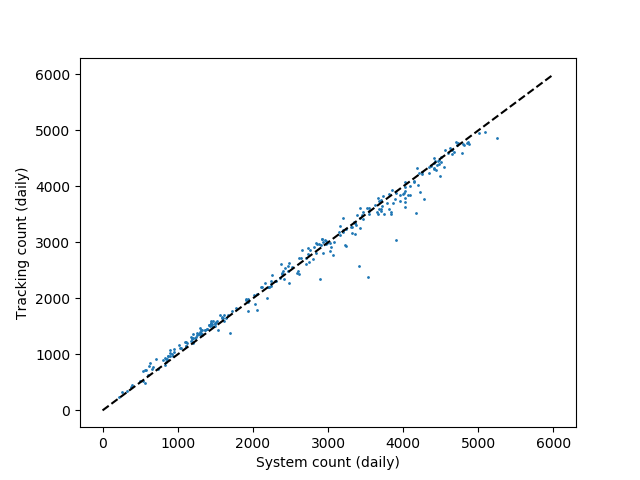

Text(0, 0.5, 'Tracking count (daily)')

In [211]:
f,ax = plt.subplots()
ax.scatter(system_daily_df,tracking_daily_df,s=1)
ax.plot([0,6000],[0,6000],color='k',linestyle='--')
ax.set_xlabel('System count (daily)')
ax.set_ylabel('Tracking count (daily)')

Not bad! I do see a bit of a trend: overcounting trips on slow days and undercounting trips on busy days. This tracks with the limitations I've mentioned above. On slow days there's few collision events, so the error is dominated by re-balancings. As the days get busier, we get more and more collisions until they become the dominant error and I start under counting trips. The half-dozen or so large outliers are due to my tracker going down for hours at a time and missing hundreds of trips (note that all the large outliers are under-estimates).

In [192]:
delta = system_daily_df - tracking_daily_df

The [Bland-Altman plot](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot) is often used to visualize systematic difference between two measurement types. Here we plot the average of the two measurements on the x axis and the difference between the two measurments on the y axis. A slope in the observed measurements implies a bias in one of the measurements.

In [202]:
average = (system_daily_df + tracking_daily_df)/2

<IPython.core.display.Javascript object>


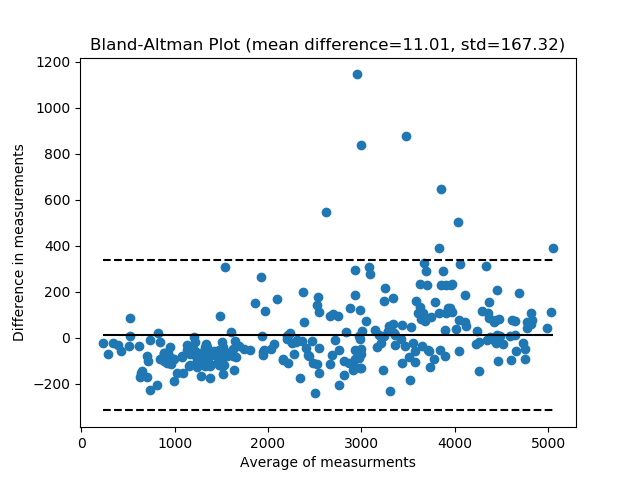

Text(0.5, 1.0, 'Bland-Altman Plot (mean difference=11.01, std=167.32)')

In [214]:
f,ax = plt.subplots()
ax.scatter(x=average,y=delta)
ax.hlines(delta.mean(),average.min(),average.values.max(),linestyles='solid')
ax.hlines([delta.mean()+delta.std()*1.96,delta.mean()-delta.std()*1.96],
          average.min(),average.values.max(),linestyles='dashed')
ax.set_ylabel('Difference in measurements')
ax.set_xlabel('Average of measurments')
ax.set_title(f'Bland-Altman Plot (mean difference={delta.mean():.02f}, std={delta.std():.02f})')

We observe a slight bias between low and high count days as discussed above. But the vast majority of observations are within 2 standard deviations of the mean, which implies that in general we have good agreement between the two methods. 

## Summary

In general, the above algorithm is a good technique for estimating trip counts from a bikeshare system's GBFS feed. Comparing the results of this technique with Mobi's official trip data shows strong correlation. Some bias is likely caused by rebalancing of bikes by the operator (noticeable on low-trip days) as well as missed trips when a bike is parked at the same time as a bike is being taken out at the same station (more noticeable on high-trip days). 

Further improvements could be made by filtering out events that are likely rebalancings (6+ bikes coming or going from a single station at the same time) and correcting for missed trips due to simultaneous events. I hope to revisit this blog when I've implemented these features and see if they improve the performance.